In [29]:
# numpy provides arrays and useful functions for working with them
import numpy
# scipy.special for the sigmoid function expit()
import scipy.special
# scipy.ndimage for rotating image arrays
import scipy.ndimage

import matplotlib.pyplot
# ensure the plots are inside this notebook, not an external window
%matplotlib inline

In [30]:
# scipy.ndimage for rotating image arrays
import scipy.ndimage

# helper to load data from PNG image files
import imageio
# glob helps select multiple files using patterns
import glob

In [31]:
# open the CSV file and read its contents into a list
data_file = open("mnist_dataset/mnist_train_100.csv", 'r')
data_list = data_file.readlines()
data_file.close()

In [32]:
# which record will be use
record = 6

In [33]:

# scale input to range 0.01 to 1.00
all_values = data_list[record].split(',')
scaled_input = ((numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01).reshape(28,28)

In [34]:
print(numpy.min(scaled_input))
print(numpy.max(scaled_input))

0.01
1.0


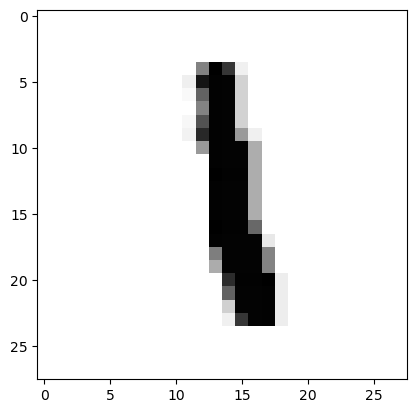

In [35]:
# plot the original image
matplotlib.pyplot.imshow(scaled_input, cmap='Greys', interpolation='None')

In [36]:
# create rotated variations
# rotated anticlockwise by 10 degrees
inputs_plus10_img = scipy.ndimage.rotate(scaled_input, 10.0, cval=0.01, order=1, reshape=False)
# rotated clockwise by 10 degrees
inputs_minus10_img = scipy.ndimage.rotate(scaled_input, -10.0, cval=0.01, order=1, reshape=False)

In [37]:
print(numpy.min(inputs_plus10_img))
print(numpy.max(inputs_plus10_img))

0.009999999999999998
0.9974879535602992


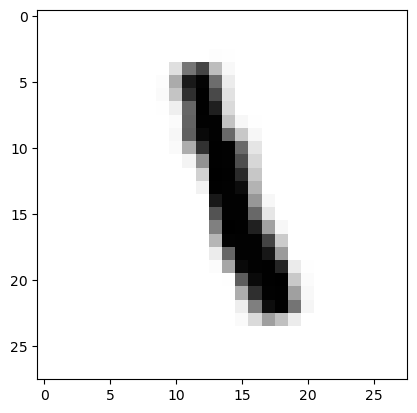

In [38]:

# plot the +10 degree rotated variation
matplotlib.pyplot.imshow(inputs_plus10_img, cmap='Greys', interpolation='None')

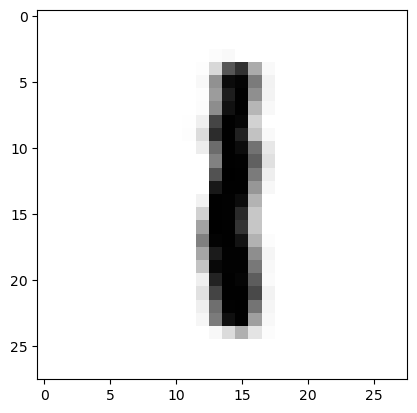

In [39]:
# plot the +10 degree rotated variation
matplotlib.pyplot.imshow(inputs_minus10_img, cmap='Greys', interpolation='None')

In [40]:
# neural network class definition
class neuralNetwork:
    
    # initialise the neural network
    def __init__(self, inputnodes, hiddennodes, outputnodes, learningrate):
        # set number of nodes in each input, hidden, output layer
        self.inodes = inputnodes
        self.hnodes = hiddennodes
        self.onodes = outputnodes
        
        # link weight matrices, wih and who
        # weights insitde the arrays are w_i_j, where link is from node i to node j in the next layer
        # w11 w21
        # w12 w22 etc
        self.wih = numpy.random.normal(0.0, pow(self.hnodes, -0.5), (self.hnodes, self.inodes))
        self.who = numpy.random.normal(0.0, pow(self.onodes, -0.5), (self.onodes, self.hnodes))
        
        # learing rate
        self.lr = learningrate
        
        # activation function is the sigmoid function
        self.activation_function = lambda x: scipy.special.expit(x)
        self.inverse_activation_function = lambda x: scipy.special.logit(x)
        
        pass
    
    
    # train the neural network    
    def train(self, inputs_list, target_list):
        # convert inputs list to 2d array
        inputs = numpy.array(inputs_list, ndmin=2).T
        targets = numpy.array(target_list, ndmin=2).T
        
        # calculate signals into hidden layer
        hidden_inputs = numpy.dot(self.wih, inputs)
        # calculate the signals emerging from hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # calculate signals into final output layer
        final_inputs = numpy.dot(self.who, hidden_outputs)
        # calculate the isnals emerging from final output layer
        final_outputs = self.activation_function(final_inputs)
        
        # output layer error is the (target - actual)
        output_errors = targets - final_outputs
        # hidden layer error is the output_errors, spilt by weights, recombined at hidden nodes
        hidden_errors = numpy.dot(self.who.T, output_errors)
        
        # update the weights for the links between the hidden and output layers
        self.who += self.lr * numpy.dot((output_errors * final_outputs * (1.0 - final_outputs)), numpy.transpose(hidden_outputs))
        
        # update the weights for the links between the input and hidden layers
        self.wih += self.lr * numpy.dot((hidden_errors * hidden_outputs * (1.0 - hidden_outputs)), numpy.transpose(inputs))
        
        pass
    
    
    # query the neural network
    def query(self, inputs_list):
        #convert inputs list to 2d array
        inputs = numpy.array(inputs_list, ndmin=2).T
        
        # calculate signals into hidden layer
        hidden_inputs = numpy.dot(self.wih, inputs)
        # calculate the signals emerging from hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # calculate signals into final output layer
        final_inputs = numpy.dot(self.who, hidden_outputs)
        # calculate the signals emerging from final output layer
        final_outputs =  self.activation_function(final_inputs)
        
        return final_outputs
    
    
    # backquery the neural network
    # we'll use the same termnimology to each item, 
    # eg target are the values at the right of the network, albeit used as input
    # eg hidden_output is the signal to the right of the middle nodes
    def backquery(self, targets_list):
        # transpose the targets list to a vertical array
        final_outputs = numpy.array(targets_list, ndmin=2).T
        
        # calculate the signal into the final output layer
        final_inputs = self.inverse_activation_function(final_outputs)

        # calculate the signal out of the hidden layer
        hidden_outputs = numpy.dot(self.who.T, final_inputs)
        # scale them back to 0.01 to .99
        hidden_outputs -= numpy.min(hidden_outputs)
        hidden_outputs /= numpy.max(hidden_outputs)
        hidden_outputs *= 0.98
        hidden_outputs += 0.01
        
        # calculate the signal into the hidden layer
        hidden_inputs = self.inverse_activation_function(hidden_outputs)
        
        # calculate the signal out of the input layer
        inputs = numpy.dot(self.wih.T, hidden_inputs)
        # scale them back to 0.01 to .99
        inputs -= numpy.min(inputs)
        inputs /= numpy.max(inputs)
        inputs *= 0.98
        inputs += 0.01
        
        return inputs

In [41]:
# the following shows the creation of a small network with 3 nodes in each of the input, hidden and output layers,
# and queries it with a randomly chosen input of (1.0, 0,5, -1,5).

# number of input, hidden and output nodes
input_nodes = 784
hidden_nodes = 200
output_nodes = 10

# learing rate
learning_rate = 0.1

# create instance of neural network
n = neuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate)

In [42]:
# load the mnist training data CSV file into a list
training_data_file = open("mnist_dataset/mnist_train.csv", 'r')
training_data_list = training_data_file.readlines()
training_data_file.close()

In [43]:
# train the neural network
    
# epochs is the number of times th etraining data set is used for training
epochs = 10

for e in range(epochs):
    # go through all records in the training data set 
    for record in training_data_list:
        # split the record by the ',' commas
        all_values = record.split(',')
        # scale and shift the inputs
        inputs = (numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
        # create the target output values (all 0.01, expect the desired lable which is 0.99)
        targets = numpy.zeros(output_nodes) + 0.01
        # all_values[0] is the target lable for this record
        targets[int(all_values[0])] = 0.99
        n.train(inputs, targets)
        
        ## create rotated variations
        # rotated anticlockwise by x degrees
        #inputs_plusx_img = scipy.ndimage.interpolation.rotate(inputs.reshape(28,28), 10, cval=0.01, order=1, reshape=False)
        #n.train(inputs_plusx_img.reshape(784), targets)
        # rotated clockwise by x degrees
        #inputs_minusx_img = scipy.ndimage.interpolation.rotate(inputs.reshape(28,28), -10, cval=0.01, order=1, reshape=False)
        #n.train(inputs_minusx_img.reshape(784), targets)
        
        # rotated anticlockwise by 10 degrees
        inputs_plus10_img = scipy.ndimage.interpolation.rotate(inputs.reshape(28,28), 10, cval=0.01, order=1, reshape=False)
        n.train(inputs_plus10_img.reshape(784), targets)
        # rotated clockwise by 10 degrees
        inputs_minus10_img = scipy.ndimage.interpolation.rotate(inputs.reshape(28,28), -10, cval=0.01, order=1, reshape=False)
        n.train(inputs_minus10_img.reshape(784), targets)
        
        pass
    pass

C:\Users\anika\AppData\Local\Temp\ipykernel_28576\1695195737.py:28: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  inputs_plus10_img = scipy.ndimage.interpolation.rotate(inputs.reshape(28,28), 10, cval=0.01, order=1, reshape=False)
C:\Users\anika\AppData\Local\Temp\ipykernel_28576\1695195737.py:31: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  inputs_minus10_img = scipy.ndimage.interpolation.rotate(inputs.reshape(28,28), -10, cval=0.01, order=1, reshape=False)


In [44]:
# load the mnist test data CSV file into a list
test_data_file = open("mnist_dataset/mnist_test.csv", 'r')
test_data_list = test_data_file.readlines()
test_data_file.close()

In [45]:
# get the first test record
all_values = test_data_list[0].split(',')
# print the lable
print(all_values[0])

7


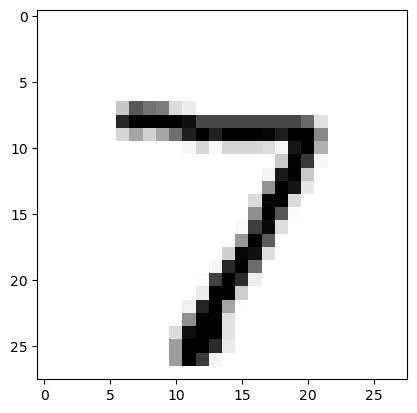

In [46]:
image_array = numpy.asfarray(all_values[1:]).reshape((28,28))
matplotlib.pyplot.imshow(image_array, cmap='Greys', interpolation='None')

In [47]:
n.query((numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01)

array([[0.00654362],
       [0.02492926],
       [0.00909206],
       [0.00706211],
       [0.0206827 ],
       [0.00332252],
       [0.02125811],
       [0.99956905],
       [0.0015144 ],
       [0.00381591]])

In [48]:
# test the neural network

# scorecard for how well the network performs, initially empty
scorecard = []

# go through all the records in the test data set
for record in test_data_list:
    # split th erecord by the ',' commas
    all_values = record.split(',')
    # correct answer is first value
    correct_label = int(all_values[0])
    print(correct_label, "correct label")
    # scale and shift the inputs
    inputs = (numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
    # query the network
    outputs = n.query(inputs)
    # the index of the highest value corresponds to the label
    label = numpy.argmax(outputs)
    print(label, "network's answer")
    # append correct or incorrect to list
    if (label == correct_label):
        # network's answer matches correct answer, add 1 to scorecard
        scorecard.append(1)
    else:
        # network's answer doesn't match correct answer, add 0 to scorecard
        scorecard.append(0)
        pass
    pass

            

7 correct label
7 network's answer
2 correct label
2 network's answer
1 correct label
1 network's answer
0 correct label
0 network's answer
4 correct label
4 network's answer
1 correct label
1 network's answer
4 correct label
4 network's answer
9 correct label
9 network's answer
5 correct label
5 network's answer
9 correct label
9 network's answer
0 correct label
0 network's answer
6 correct label
6 network's answer
9 correct label
9 network's answer
0 correct label
0 network's answer
1 correct label
1 network's answer
5 correct label
5 network's answer
9 correct label
9 network's answer
7 correct label
7 network's answer
3 correct label
3 network's answer
4 correct label
4 network's answer
9 correct label
9 network's answer
6 correct label
6 network's answer
6 correct label
6 network's answer
5 correct label
5 network's answer
4 correct label
4 network's answer
0 correct label
0 network's answer
7 correct label
7 network's answer
4 correct label
4 network's answer
0 correct label
0 ne

5 network's answer
5 correct label
5 network's answer
4 correct label
4 network's answer
0 correct label
0 network's answer
8 correct label
8 network's answer
2 correct label
2 network's answer
1 correct label
1 network's answer
0 correct label
0 network's answer
8 correct label
8 network's answer
4 correct label
4 network's answer
5 correct label
8 network's answer
0 correct label
0 network's answer
4 correct label
4 network's answer
0 correct label
0 network's answer
6 correct label
6 network's answer
1 correct label
1 network's answer
7 correct label
7 network's answer
3 correct label
3 network's answer
2 correct label
2 network's answer
6 correct label
6 network's answer
7 correct label
7 network's answer
2 correct label
2 network's answer
6 correct label
6 network's answer
9 correct label
9 network's answer
3 correct label
3 network's answer
1 correct label
1 network's answer
4 correct label
4 network's answer
6 correct label
6 network's answer
2 correct label
2 network's answer
5

5 network's answer
4 correct label
4 network's answer
0 correct label
0 network's answer
2 correct label
2 network's answer
8 correct label
8 network's answer
7 correct label
2 network's answer
2 correct label
2 network's answer
9 correct label
9 network's answer
8 correct label
8 network's answer
4 correct label
4 network's answer
0 correct label
0 network's answer
9 correct label
9 network's answer
5 correct label
5 network's answer
8 correct label
8 network's answer
5 correct label
5 network's answer
1 correct label
1 network's answer
2 correct label
2 network's answer
1 correct label
1 network's answer
3 correct label
3 network's answer
1 correct label
1 network's answer
7 correct label
7 network's answer
4 correct label
9 network's answer
5 correct label
5 network's answer
7 correct label
7 network's answer
2 correct label
2 network's answer
0 correct label
0 network's answer
9 correct label
0 network's answer
8 correct label
8 network's answer
8 correct label
8 network's answer
6

1 network's answer
1 correct label
1 network's answer
6 correct label
6 network's answer
7 correct label
7 network's answer
6 correct label
6 network's answer
3 correct label
3 network's answer
2 correct label
2 network's answer
2 correct label
2 network's answer
0 correct label
0 network's answer
8 correct label
8 network's answer
9 correct label
9 network's answer
2 correct label
2 network's answer
5 correct label
5 network's answer
1 correct label
1 network's answer
0 correct label
0 network's answer
8 correct label
8 network's answer
1 correct label
1 network's answer
9 correct label
4 network's answer
5 correct label
5 network's answer
7 correct label
2 network's answer
9 correct label
9 network's answer
6 correct label
6 network's answer
9 correct label
9 network's answer
0 correct label
0 network's answer
6 correct label
4 network's answer
1 correct label
1 network's answer
5 correct label
5 network's answer
5 correct label
6 network's answer
8 correct label
8 network's answer
3

9 network's answer
3 correct label
3 network's answer
8 correct label
8 network's answer
9 correct label
9 network's answer
5 correct label
5 network's answer
3 correct label
3 network's answer
7 correct label
7 network's answer
9 correct label
9 network's answer
1 correct label
1 network's answer
7 correct label
7 network's answer
0 correct label
0 network's answer
0 correct label
0 network's answer
3 correct label
3 network's answer
7 correct label
7 network's answer
2 correct label
2 network's answer
5 correct label
5 network's answer
8 correct label
8 network's answer
1 correct label
1 network's answer
8 correct label
8 network's answer
6 correct label
6 network's answer
2 correct label
2 network's answer
9 correct label
9 network's answer
5 correct label
5 network's answer
7 correct label
7 network's answer
5 correct label
5 network's answer
7 correct label
3 network's answer
8 correct label
8 network's answer
6 correct label
6 network's answer
2 correct label
2 network's answer
5

4 network's answer
7 correct label
7 network's answer
1 correct label
1 network's answer
6 correct label
6 network's answer
2 correct label
2 network's answer
9 correct label
9 network's answer
9 correct label
9 network's answer
0 correct label
0 network's answer
0 correct label
0 network's answer
1 correct label
1 network's answer
8 correct label
8 network's answer
8 correct label
8 network's answer
4 correct label
4 network's answer
3 correct label
3 network's answer
4 correct label
4 network's answer
2 correct label
2 network's answer
0 correct label
0 network's answer
6 correct label
6 network's answer
1 correct label
1 network's answer
6 correct label
6 network's answer
1 correct label
1 network's answer
2 correct label
2 network's answer
2 correct label
2 network's answer
2 correct label
2 network's answer
1 correct label
1 network's answer
2 correct label
2 network's answer
3 correct label
3 network's answer
7 correct label
7 network's answer
8 correct label
8 network's answer
1

1 network's answer
5 correct label
5 network's answer
1 correct label
1 network's answer
4 correct label
6 network's answer
8 correct label
8 network's answer
8 correct label
8 network's answer
9 correct label
9 network's answer
1 correct label
1 network's answer
2 correct label
2 network's answer
1 correct label
1 network's answer
3 correct label
3 network's answer
5 correct label
5 network's answer
1 correct label
1 network's answer
0 correct label
0 network's answer
9 correct label
9 network's answer
4 correct label
4 network's answer
4 correct label
4 network's answer
8 correct label
8 network's answer
3 correct label
3 network's answer
2 correct label
2 network's answer
5 correct label
5 network's answer
9 correct label
9 network's answer
7 correct label
7 network's answer
6 correct label
6 network's answer
6 correct label
6 network's answer
2 correct label
2 network's answer
0 correct label
0 network's answer
0 correct label
0 network's answer
0 correct label
0 network's answer
5

1 network's answer
1 correct label
1 network's answer
8 correct label
8 network's answer
3 correct label
7 network's answer
5 correct label
5 network's answer
1 correct label
1 network's answer
9 correct label
9 network's answer
5 correct label
5 network's answer
3 correct label
3 network's answer
5 correct label
5 network's answer
4 correct label
4 network's answer
9 correct label
9 network's answer
5 correct label
5 network's answer
9 correct label
9 network's answer
3 correct label
3 network's answer
1 correct label
1 network's answer
9 correct label
9 network's answer
0 correct label
0 network's answer
9 correct label
9 network's answer
7 correct label
7 network's answer
5 correct label
5 network's answer
4 correct label
4 network's answer
9 correct label
9 network's answer
2 correct label
2 network's answer
0 correct label
0 network's answer
1 correct label
1 network's answer
0 correct label
0 network's answer
5 correct label
5 network's answer
1 correct label
1 network's answer
4

4 network's answer
6 correct label
6 network's answer
9 correct label
9 network's answer
7 correct label
7 network's answer
2 correct label
2 network's answer
1 correct label
1 network's answer
5 correct label
5 network's answer
1 correct label
1 network's answer
4 correct label
4 network's answer
6 correct label
6 network's answer
3 correct label
3 network's answer
8 correct label
4 network's answer
1 correct label
1 network's answer
1 correct label
1 network's answer
0 correct label
0 network's answer
3 correct label
3 network's answer
1 correct label
1 network's answer
6 correct label
6 network's answer
8 correct label
8 network's answer
4 correct label
4 network's answer
9 correct label
9 network's answer
0 correct label
0 network's answer
7 correct label
7 network's answer
3 correct label
3 network's answer
0 correct label
0 network's answer
2 correct label
2 network's answer
9 correct label
9 network's answer
0 correct label
0 network's answer
6 correct label
6 network's answer
6

4 network's answer
7 correct label
7 network's answer
3 correct label
3 network's answer
0 correct label
0 network's answer
9 correct label
9 network's answer
1 correct label
1 network's answer
4 correct label
4 network's answer
5 correct label
5 network's answer
4 correct label
4 network's answer
6 correct label
6 network's answer
2 correct label
2 network's answer
0 correct label
0 network's answer
6 correct label
6 network's answer
2 correct label
2 network's answer
1 correct label
1 network's answer
1 correct label
1 network's answer
1 correct label
1 network's answer
1 correct label
1 network's answer
7 correct label
7 network's answer
2 correct label
2 network's answer
4 correct label
4 network's answer
7 correct label
7 network's answer
5 correct label
5 network's answer
2 correct label
2 network's answer
9 correct label
9 network's answer
4 correct label
4 network's answer
5 correct label
5 network's answer
8 correct label
8 network's answer
4 correct label
4 network's answer
2

6 network's answer
1 correct label
1 network's answer
5 correct label
5 network's answer
7 correct label
7 network's answer
4 correct label
4 network's answer
6 correct label
6 network's answer
1 correct label
1 network's answer
2 correct label
2 network's answer
5 correct label
5 network's answer
0 correct label
0 network's answer
7 correct label
7 network's answer
9 correct label
9 network's answer
9 correct label
9 network's answer
0 correct label
0 network's answer
3 correct label
3 network's answer
8 correct label
8 network's answer
4 correct label
3 network's answer
4 correct label
4 network's answer
8 correct label
8 network's answer
1 correct label
1 network's answer
8 correct label
8 network's answer
6 correct label
6 network's answer
5 correct label
5 network's answer
9 correct label
9 network's answer
0 correct label
0 network's answer
0 correct label
0 network's answer
0 correct label
0 network's answer
3 correct label
3 network's answer
7 correct label
7 network's answer
1

6 network's answer
7 correct label
7 network's answer
8 correct label
8 network's answer
0 correct label
0 network's answer
1 correct label
1 network's answer
2 correct label
2 network's answer
3 correct label
3 network's answer
4 correct label
4 network's answer
5 correct label
5 network's answer
6 correct label
6 network's answer
7 correct label
7 network's answer
8 correct label
8 network's answer
2 correct label
2 network's answer
1 correct label
1 network's answer
7 correct label
7 network's answer
2 correct label
2 network's answer
5 correct label
5 network's answer
0 correct label
0 network's answer
8 correct label
8 network's answer
0 correct label
0 network's answer
2 correct label
2 network's answer
7 correct label
7 network's answer
8 correct label
8 network's answer
8 correct label
8 network's answer
3 correct label
3 network's answer
6 correct label
6 network's answer
0 correct label
0 network's answer
2 correct label
2 network's answer
7 correct label
7 network's answer
6

8 network's answer
8 correct label
8 network's answer
3 correct label
3 network's answer
0 correct label
0 network's answer
6 correct label
6 network's answer
0 correct label
0 network's answer
2 correct label
2 network's answer
7 correct label
7 network's answer
6 correct label
6 network's answer
6 correct label
6 network's answer
1 correct label
1 network's answer
2 correct label
2 network's answer
8 correct label
8 network's answer
8 correct label
8 network's answer
7 correct label
7 network's answer
7 correct label
7 network's answer
4 correct label
4 network's answer
7 correct label
7 network's answer
7 correct label
7 network's answer
3 correct label
3 network's answer
7 correct label
7 network's answer
4 correct label
4 network's answer
5 correct label
5 network's answer
4 correct label
4 network's answer
3 correct label
3 network's answer
3 correct label
3 network's answer
8 correct label
8 network's answer
4 correct label
4 network's answer
5 correct label
5 network's answer
4

1 network's answer
5 correct label
5 network's answer
0 correct label
0 network's answer
8 correct label
8 network's answer
5 correct label
5 network's answer
0 correct label
0 network's answer
1 correct label
1 network's answer
5 correct label
5 network's answer
8 correct label
8 network's answer
4 correct label
4 network's answer
2 correct label
2 network's answer
3 correct label
3 network's answer
9 correct label
9 network's answer
7 correct label
7 network's answer
6 correct label
6 network's answer
9 correct label
9 network's answer
1 correct label
1 network's answer
9 correct label
9 network's answer
0 correct label
0 network's answer
6 correct label
6 network's answer
7 correct label
7 network's answer
1 correct label
1 network's answer
2 correct label
2 network's answer
3 correct label
3 network's answer
9 correct label
9 network's answer
2 correct label
2 network's answer
4 correct label
4 network's answer
5 correct label
5 network's answer
5 correct label
5 network's answer
3

1 network's answer
2 correct label
2 network's answer
3 correct label
3 network's answer
4 correct label
4 network's answer
5 correct label
5 network's answer
6 correct label
6 network's answer
7 correct label
7 network's answer
8 correct label
8 network's answer
9 correct label
9 network's answer
0 correct label
0 network's answer
1 correct label
1 network's answer
2 correct label
2 network's answer
3 correct label
3 network's answer
4 correct label
4 network's answer
5 correct label
5 network's answer
6 correct label
6 network's answer
9 correct label
9 network's answer
0 correct label
0 network's answer
1 correct label
1 network's answer
3 correct label
3 network's answer
1 correct label
1 network's answer
5 correct label
5 network's answer
1 correct label
1 network's answer
2 correct label
2 network's answer
4 correct label
4 network's answer
9 correct label
9 network's answer
2 correct label
8 network's answer
4 correct label
4 network's answer
6 correct label
6 network's answer
8

2 network's answer
4 correct label
4 network's answer
7 correct label
7 network's answer
8 correct label
8 network's answer
0 correct label
0 network's answer
7 correct label
7 network's answer
0 correct label
0 network's answer
6 correct label
6 network's answer
9 correct label
9 network's answer
3 correct label
3 network's answer
2 correct label
2 network's answer
4 correct label
4 network's answer
8 correct label
8 network's answer
6 correct label
6 network's answer
0 correct label
0 network's answer
5 correct label
5 network's answer
7 correct label
7 network's answer
5 correct label
5 network's answer
1 correct label
1 network's answer
0 correct label
0 network's answer
8 correct label
8 network's answer
1 correct label
1 network's answer
6 correct label
6 network's answer
7 correct label
7 network's answer
2 correct label
2 network's answer
9 correct label
9 network's answer
7 correct label
7 network's answer
9 correct label
9 network's answer
5 correct label
5 network's answer
6

1 network's answer
2 correct label
2 network's answer
4 correct label
4 network's answer
5 correct label
5 network's answer
6 correct label
6 network's answer
7 correct label
7 network's answer
8 correct label
8 network's answer
9 correct label
9 network's answer
0 correct label
0 network's answer
1 correct label
1 network's answer
3 correct label
3 network's answer
4 correct label
4 network's answer
5 correct label
5 network's answer
6 correct label
6 network's answer
7 correct label
7 network's answer
8 correct label
8 network's answer
0 correct label
0 network's answer
1 correct label
1 network's answer
3 correct label
3 network's answer
4 correct label
4 network's answer
7 correct label
7 network's answer
8 correct label
8 network's answer
9 correct label
9 network's answer
7 correct label
7 network's answer
5 correct label
5 network's answer
5 correct label
5 network's answer
1 correct label
1 network's answer
9 correct label
9 network's answer
9 correct label
9 network's answer
7

9 network's answer
3 correct label
3 network's answer
8 correct label
8 network's answer
4 correct label
4 network's answer
4 correct label
4 network's answer
7 correct label
7 network's answer
0 correct label
0 network's answer
1 correct label
1 network's answer
9 correct label
9 network's answer
2 correct label
2 network's answer
8 correct label
8 network's answer
7 correct label
7 network's answer
8 correct label
8 network's answer
2 correct label
2 network's answer
6 correct label
6 network's answer
0 correct label
0 network's answer
6 correct label
6 network's answer
5 correct label
5 network's answer
3 correct label
3 network's answer
3 correct label
3 network's answer
3 correct label
9 network's answer
9 correct label
9 network's answer
1 correct label
1 network's answer
4 correct label
4 network's answer
0 correct label
0 network's answer
6 correct label
6 network's answer
1 correct label
1 network's answer
0 correct label
0 network's answer
0 correct label
0 network's answer
6

In [49]:
print(scorecard)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [50]:
# calculate the performance score, the fraction of correct answers
scorecard_array = numpy.asarray(scorecard)
print ("performance = ", scorecard_array.sum() / scorecard_array.size)

performance =  0.9705


In [62]:
# our own image test data set
our_own_dataset = []

In [63]:
# load the png image data as test data set
for image_file_name in glob.glob('my_own_images/2828_my_own_?.png'):   
    
    # use the filename to set the correct label
    label = int(image_file_name[-5:-4])
    
    # load image data from png files into an array
    print ("loading ... ", image_file_name)
    img_array = imageio.imread(image_file_name, as_gray=True)
    
    # reshape from 28x28 to list of 784 values, invert values
    img_data  = 255.0 - img_array.reshape(784)
    
    # then scale data to range from 0.01 to 1.0
    img_data = (img_data / 255.0 * 0.99) + 0.01
    print(numpy.min(img_data))
    print(numpy.max(img_data))
    
    # append label and image data  to test data set
    record = numpy.append(label,img_data)
    print(record)
    our_own_dataset.append(record)
    
    pass

loading ...  my_own_images\2828_my_own_0.png
0.01
0.9262353


C:\Users\anika\AppData\Local\Temp\ipykernel_28576\3399306375.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_array = imageio.imread(image_file_name, as_gray=True)


[0.         0.01       0.01       0.01       0.01       0.01
 0.01       0.01       0.01       0.01       0.01       0.01
 0.01       0.01       0.01       0.01       0.01       0.01
 0.01       0.01       0.01       0.01       0.01       0.01
 0.01       0.01       0.01       0.01       0.01       0.01
 0.01       0.01       0.01       0.01       0.01       0.01
 0.01       0.01       0.01       0.01       0.01       0.01
 0.01       0.01       0.01       0.01       0.01       0.01
 0.01       0.01       0.01       0.01       0.01       0.01
 0.01       0.01       0.01       0.01       0.01       0.01
 0.01       0.01       0.01       0.01       0.01       0.01
 0.01       0.01       0.01       0.01       0.01       0.01
 0.01       0.01       0.01       0.01       0.01       0.01
 0.01       0.01       0.01       0.01       0.01       0.01
 0.01       0.01       0.01       0.01       0.01       0.01
 0.01       0.01       0.01       0.01       0.01       0.01
 0.01       0.01       0

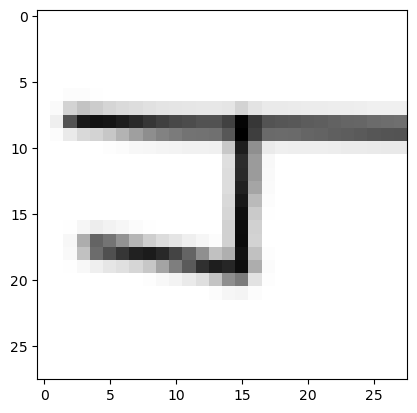

In [64]:
matplotlib.pyplot.imshow(our_own_dataset[4][1:].reshape(28,28), cmap='Greys', interpolation='None')

In [65]:
print(our_own_dataset[0])

[0.         0.01       0.01       0.01       0.01       0.01
 0.01       0.01       0.01       0.01       0.01       0.01
 0.01       0.01       0.01       0.01       0.01       0.01
 0.01       0.01       0.01       0.01       0.01       0.01
 0.01       0.01       0.01       0.01       0.01       0.01
 0.01       0.01       0.01       0.01       0.01       0.01
 0.01       0.01       0.01       0.01       0.01       0.01
 0.01       0.01       0.01       0.01       0.01       0.01
 0.01       0.01       0.01       0.01       0.01       0.01
 0.01       0.01       0.01       0.01       0.01       0.01
 0.01       0.01       0.01       0.01       0.01       0.01
 0.01       0.01       0.01       0.01       0.01       0.01
 0.01       0.01       0.01       0.01       0.01       0.01
 0.01       0.01       0.01       0.01       0.01       0.01
 0.01       0.01       0.01       0.01       0.01       0.01
 0.01       0.01       0.01       0.01       0.01       0.01
 0.01       0.01       0

[[3.45199735e-05]
 [7.51078511e-05]
 [5.55603344e-03]
 [1.00483748e-04]
 [1.07807163e-04]
 [1.61032296e-01]
 [4.18953456e-06]
 [1.44056006e-05]
 [1.12161178e-06]
 [1.89134485e-03]]
network says  5
no match!


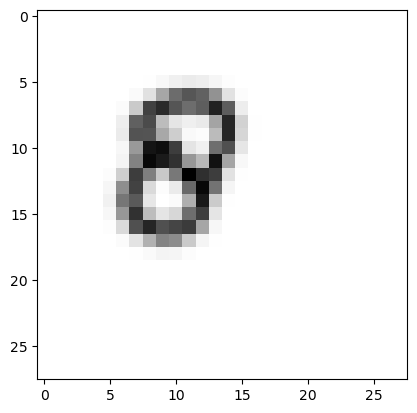

In [71]:
# test the neural network with my own images

# record to test
item = 8

# plot image
matplotlib.pyplot.imshow(our_own_dataset[item][1:].reshape(28,28), cmap='Greys', interpolation='None')

# correct answer is first value
correct_label = our_own_dataset[item][0]
# data is remaining values
inputs = our_own_dataset[item][1:]

# query the network
outputs = n.query(inputs)
print (outputs)

# the index of the highest value corresponds to the label
label = numpy.argmax(outputs)
print("network says ", label)
# append correct or incorrect to list
if (label == correct_label):
    print ("match!")
else:
    print ("no match!")
    pass

[0.01 0.01 0.01 0.01 0.01 0.99 0.01 0.01 0.01 0.01]


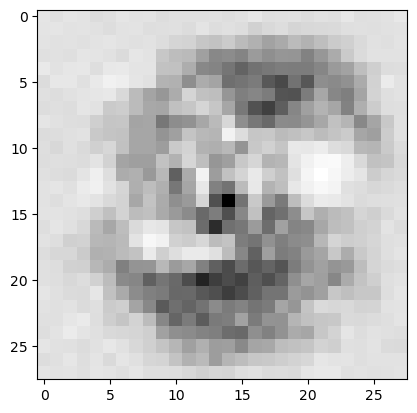

In [73]:
# run the network backwards, given a label, see what image it produces

# label to test
label = 5
# create the output signals for this label
targets = numpy.zeros(output_nodes) + 0.01
# all_values[0] is the target label for this record
targets[label] = 0.99
print(targets)

# get image data
image_data = n.backquery(targets)

# plot image data
matplotlib.pyplot.imshow(image_data.reshape(28,28), cmap='Greys', interpolation='None')